# Projeto 3 - Ciência dos Dados - Engenharia_2A - 
## Ester Quintino, Luciana de Freitas e Pedro Dias#

# Importações 

In [23]:
import pandas as pd
import json
import itertools
import matplotlib.pyplot as plt
from scipy.stats import norm, t
from scipy import stats
%matplotlib inline

### Leitura do arquivo

No Firebase os dados encontram-se ordenados como estruturas aninhadas. Vamos usar a função Export JSON no Firebase console.

<img src=firebase_object_tree.png width=200>


A função *Exportar o JSON* fica à direita na visão de base de dados:
<img src=export_json.png width=500>

In [2]:
arquivo = open("projeto3-cd-export.json")
linhas = arquivo.readlines()
texto = "".join(linhas)
dados_fire = json.loads(texto)

### Análise do atributo logs

 Veja que log, que contém todos os dados, está pesadamente aninhado

In [27]:
for k,v in dados_fire["logs"].items():
    # print(k,v) # habilite para imprimir as chaves de mais alto nível
    for chave, valor in v.items():
        # print(chave, valor) # habilite para imprimir as chaves inferiores
        pass # desabilite quando reabilitar a linha de cima



### Convertendo para um dataframe

O pandas entende listas de dicionários que têm as mesmas chaves. O Firebase nos dá dicionários de dicionários de dicionários. 

Vamos precisar converter. Basta inserir todos os itens que estavam na chave "logs" em uma lista

In [4]:
lista_dicionarios = []

for k,v in dados_fire["logs"].items():
    lista_dicionarios.append(v)

        


A função `from_records` converte a lista de dicionários em um dataframe

In [5]:
dataframe = pd.DataFrame.from_records(lista_dicionarios)

Desta forma temos o dataframe. Observe que os eventos são dos seguintes tipos:

* *inicio* - quando um usuário inicia uma tarefa
* final - quando o usuário termina uma tarefa

Precisamos agrupar pelo `id` do usuário e depois subtrair o tempo inicial do final, para sabermos quanto tempo efetivamente levou aquela tarefa

In [6]:
dataframe

,tempo,tipo,user_id,versao
0,1510862507419,inicio,1372666489,B
1,1510862539067,final,1372666489,B
2,1510862625687,inicio,3200482478,B
3,1510862630346,final,3200482478,B
4,1510913068196,inicio,801361200,A
5,1510913249861,inicio,801361200,A
6,1510913284587,inicio,801361200,A
7,1510913311744,inicio,801361200,A
8,1510913331443,inicio,801361200,A
9,1510913334966,inicio,801361200,A


### Convertendo para um DataFrame de delta_t

In [7]:
agrupado = dataframe.groupby(by=["user_id", "versao"])

In [8]:
users = set(dataframe.user_id) # We convert it to a set so that each user appear only once

In [9]:
users = list(users) 

In [10]:
resultados = []

for u in users:
    for versao in ["A", "B"]:
        if (u, versao) in agrupado.groups.keys(): # Check if a specific pair user/type of test happened
            grupo1 =  agrupado.get_group((u, versao))
            grupo1 = grupo1.sort_values(by="tempo") # Para evitar que inícios sem fim gerem tempos negativos
            
            if len(grupo1[grupo1.tipo=="final"])>= 1 and len(grupo1[grupo1.tipo=="inicio"]) >= 1:
                delta_t = grupo1[grupo1.tipo=="final"].iloc[-1].tempo - grupo1[grupo1.tipo=="inicio"].iloc[0].tempo
                resultados.append({"user_id":u, "delta_t":delta_t, "versao":versao})

In [11]:
grupo1.sort_values(by="tempo")

,tempo,tipo,user_id,versao
48,1511023052178,inicio,3157607674,B


In [12]:
dataframe_resumo = pd.DataFrame.from_records(resultados)

In [13]:
dataframe_resumo.delta_t/=1000 # Convertendo milissegundos em segundos

In [14]:
dataframe_resumo

,delta_t,user_id,versao
0,32.749,56269058,A
1,54.835,2074843654,A
2,37.034,3112869006,A
3,40.245,2876237975,B
4,52.679,3331548450,B
5,42.971,3536437668,B
6,64.420,738456492,A
7,256218.282,738456492,B
8,375.598,3200482478,A
9,416683.177,3200482478,B


In [32]:
dataframe_resumo = dataframe_resumo.loc[dataframe_resumo.delta_t < 490]
Atempo = dataframe_resumo.loc[dataframe_resumo.versao=='A',['delta_t']] # novo DataFrame em função de delta_t
Btempo = dataframe_resumo.loc[dataframe_resumo.versao=='B',['delta_t']] # novo DataFrame em função de delta_t

In [33]:
Atempo

,delta_t
0,32.749
1,54.835
2,37.034
6,64.420
8,375.598
10,483.590
14,36.557
18,22.626
21,12.015
22,41.620


In [34]:
Btempo

,delta_t
3,40.245
4,52.679
5,42.971
11,42.603
12,13.168
15,130.890
16,272.349
17,22.265
19,26.730
20,33.978


# Comparação dos histogramas

(array([ 9.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.]),
 array([  12.015 ,   59.1725,  106.33  ,  153.4875,  200.645 ,  247.8025,
         294.96  ,  342.1175,  389.275 ,  436.4325,  483.59  ]),
 <a list of 10 Patch objects>)

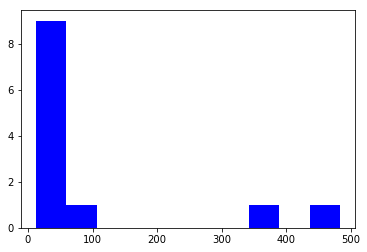

In [35]:
plt.hist(Atempo.delta_t, bins=10, color="blue")

(array([ 7.,  5.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([  12.386 ,   38.3823,   64.3786,   90.3749,  116.3712,  142.3675,
         168.3638,  194.3601,  220.3564,  246.3527,  272.349 ]),
 <a list of 10 Patch objects>)

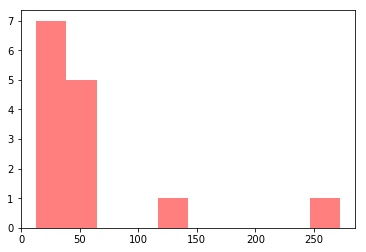

In [36]:
plt.hist(Btempo.delta_t, bins=10, alpha=0.5, color="red")

### Para avaliarmos qual portifólio é mais eficiente, realizaremos uma comparação por proporção de amostras independentes com variâncias desconhecidas e independentes.  Para isso temos duas hipóteses: H0 (μA - μB = 0) e H1 (μA - μB !=0). Com elas realizaremos uma cdf da distribuição t_student a fim de descobrimos se rejeitamos ou não a hipótese nula.

# Destribuição t_student

In [37]:
nA = len(Atempo.delta_t)
nB = len(Btempo.delta_t)

In [41]:
μA = Atempo.mean()
μB = Btempo.mean()
D = μA - μB 
SA = (((Atempo).var())/(nA - 1))**(0.5)
SB = (((Btempo).var())/(nB-1))**(0.5)
T = D/((((SA**2)/nA + (SB)**2)/nB)**(0.5))
v = (((SA**2)/nA + (SB**2)/(nB))**(2))/(((SA/nA)**2)/(nA-1) + ((SB/nB)**2)/(nB-1))

In [45]:
Value_P = t.cdf(-T,loc = 0, scale = 1, df = v )*2
Value_P

array([  4.40314206e-13])

** R. Com esse resultado concluímos que como Value_P < alpha, esse sendo 5%, observamos que devemos rejeitar a hipótese nula H0:μA - μB = 0, pois a chance desse experimento acontecer e as médias serem iguais é praticamente nula. **

# Conclusão

In [46]:
#H1 μA - μB != 0
Dh1 = μA - μB
Dh1

delta_t    45.317988
dtype: float64

** Com esse resultado concluímos que como Dh1 > 0 e μA > μB, as pessoas tiveram mais dificuldade em achar o projeto em questão no portifólio A do que no B. Sendo assim conclui-se que o portifólio B é mais eficiente. **